# Introduction to Transfer Learning
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

### Lesson Reference
To supplement the presented material, consult the tutorial here: https://www.tensorflow.org/beta/tutorials/images/transfer_learning
* Freeze most layers, update only certain layer(s), then unfreeze all and update

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/03_04_CNN_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/03_04_CNN_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### Normalize Environments
Run the first two cells to normalize Local / Colab environments, then proceed below for the lesson.

In [1]:
from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    os.chdir('..')
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
    # Setup tensorflow 2.0
    !pip install -q tensorflow-gpu==2.0.0-beta0
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

In [3]:
# Additional imports
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from indl import turbo_cmap, reset_keras

# %load_ext tensorboard
plt.rcParams.update({'font.size': 22})
%load_ext autoreload
%autoreload 2

In [4]:
# Download and unzip data
datadir = Path.cwd() / 'data' / 'kjm_ecog'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download --unzip --path {str(datadir / 'converted' / 'faces_basic')} cboulay/kjm-ecog-faces-basic
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


## Strategy

The model comprises a block for temporal filters, a block for a spatial filter, a block for further convolutional layers, and a block for the classifier. The spatial filter is going to be unique to each recording, but the other blocks could be shared across recordings.

If we start with a well-performing model for one recording then whenever we switch to a new recording the different sensor locations are going to be a poor fit and create large errors. We don't want those errors to propagate through and update weights in the entire model. For each new recording, we freeze the layers that are shared so they don't update, and we allow only the spatial filter to update. After the spatial filter has updated, we can then unfreeze all layers to perform fine tuning at a lower learning rate.

In [5]:
participant_names = ['ja', 'ca', 'wc', 'de', 'zt', 'fp']
test_participant = 'mv'  # To validate the transfer-learning model vs a naive model.

In [6]:
from data.utils.fileio import load_faces_houses

X, Y, ax_info = load_faces_houses(datadir, participant_names[-1], feature_set='full')
n_trials = len(ax_info['instance_data'])

print("Found {} trials, {} timestamps ({} to {} at {} Hz), {} channels".format(
    n_trials, len(ax_info['timestamps']), ax_info['timestamps'][0], ax_info['timestamps'][-1],
    ax_info['fs'], X.shape[-1]))

Found 603 trials, 801 timestamps (-0.2 to 0.6 at 1000 Hz), 52 channels


### Define the model in parts

In [20]:
# EEGNet-like model with a pair of parallel input layers.
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import layers

def make_models(T, C, aug_offset=100, n_classes=3,
                n_temporal_short=7, len_temporal_short=38,
                n_temporal_long=4, len_temporal_long=120,
                D=4,
                activation='relu',
                downsamp_1=5,
                n_pointwise_filters=36,
                len_kernel_2=16, downsamp_2=7,
                norm_rate=0.45, dropout_rate=0.45, l2_reg=0.0002,
                optimizer_lr=0.0001,
                participant_names=[]):

    # Shared head block:
    # Temporal kernel convolutions.
    _input = tf.keras.Input(shape=(T - aug_offset, C, 1))
    
    _y_short = layers.Conv2D(n_temporal_short, (len_temporal_short, 1),
                             padding='same', use_bias=False)(_input)
    _y_long = layers.Conv2D(n_temporal_long, (len_temporal_long, 1),
                            padding='same', use_bias=False)(_input)
    _y = layers.Concatenate(axis=-1)([_y_short, _y_long])
    _y = layers.BatchNormalization(axis=1)(_y)
    shared_head = tf.keras.Model(inputs=_input, outputs=_y, name='shared_head')
    shared_head.summary()
    
    # Skip over the spatial filter for now and do
    # Shared tail block: Feature aggregation and classification
    _input_2 = tf.keras.Input(shape=(T - aug_offset, 1,
                                     (n_temporal_short + n_temporal_long) * D ))
    _y = layers.AveragePooling2D((downsamp_1, 1))(_y)
    _y = layers.Dropout(dropout_rate)(_y)
    _y = layers.SeparableConv2D(n_pointwise_filters, (len_kernel_2, 1), padding='valid',
                                use_bias=False)(_input_2)
    _y = layers.Activation(activation)(_y)
    _y = layers.BatchNormalization(axis=1)(_y)
    _y = layers.AveragePooling2D((downsamp_2, 1))(_y)
    _y = layers.Dropout(dropout_rate)(_y)
    # To class predictions
    _y = layers.Flatten()(_y)
    _y = layers.Dense(n_classes, kernel_constraint=max_norm(norm_rate))(_y)
    _y = layers.Activation('softmax')(_y)
    shared_tail = tf.keras.Model(inputs=_input_2, outputs=_y, name='shared_tail')
    shared_tail.summary()
    
    optimizer = tf.keras.optimizers.RMSprop(lr=optimizer_lr)
    
    # Create full models for each participant, with each having a unique spatial filter.
    ss_models = {}
    for ss_ix, ss_name in enumerate(participant_names):
        _input_3 = tf.keras.Input(shape=(T - aug_offset, C, 1))
        
        # Common head
        _y = shared_head(_input_3)
        
        # Spatial Filter
        _y = layers.DepthwiseConv2D((1, C), use_bias=False,
                                    depth_multiplier=D,
                                    kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                    depthwise_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                    depthwise_constraint=max_norm(1.))(_y)
        # The order of Activation and BathNormalization is switched here compared to EEGNet.
        # This is because we use relu. relu after normalization discards too much data.
        _y = layers.Activation(activation)(_y)
        _y = layers.BatchNormalization(axis=1)(_y)
        
        # Common tail
        _y = shared_tail(_y)
        
        ss_model = tf.keras.Model(inputs=_input_3, outputs=_y, name=ss_name)
        ss_model.compile(loss='sparse_categorical_crossentropy',
                         optimizer=optimizer, metrics=['accuracy'])
        ss_models[ss_name] = ss_model
    
    return shared_head, shared_tail, ss_models

In [21]:
MAX_OFFSET = 100
all_ss = participant_names + [test_participant]
shared_head, shared_tail, ss_models = make_models(X.shape[1], X.shape[2],
                                                  n_classes=len(np.unique(Y)),
                                                  aug_offset=MAX_OFFSET,
                                                  participant_names=all_ss)
ss_models[test_participant].summary()

Model: "shared_head"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 701, 52, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 701, 52, 7)   266         input_19[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 701, 52, 4)   480         input_19[0][0]                   
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 701, 52, 11)  0           conv2d_8[0][0]                   
                                                                 conv2d_9[0][0]         

#### Prepare Data

In [7]:
def get_ds_train_valid(X, Y, trn, tst, batch_size=5, max_offset=0):
    # Convert Y from strings to integers.
    classes, y = np.unique(Y, return_inverse=True)
    n_trials = len(y)
    n_subsamps = X.shape[1] - max_offset
    
    def augmentation_fn(x_dat, y_dat):
        # Randomly select an integer between 0 and max_offset
        t_offset = tf.random.uniform(shape=[], minval=0, maxval=max_offset, dtype=tf.int32)
        # Slice the data to keep samples from t_offset to t_offset + n_subsamps
        # tf.slice syntax arguments are: data, slice starts (per dim), slice length (per dim)
        # Though -1 as a length is special, and means to take all.
        x_dat = tf.slice(x_dat, [t_offset, 0, 0], [n_subsamps, -1, -1])
        return x_dat, y_dat
    
    def augmentation_valid_fn(x_dat, y_dat):
        # For validation data, take only the last n_subsamps
        x_dat = tf.slice(x_dat, [max_offset, 0, 0], [n_subsamps, -1, -1])
        return x_dat, y_dat
    
    def preprocess_fn(x_dat, y_dat):
        # Data are by default 64-bit. GPUs work better with 32-bit (or even 16-bit, depending)
        x_dat = tf.cast(x_dat, tf.float32)
        # keras Conv layers expect a 'colour depth' dimension.
        x_dat = tf.expand_dims(x_dat, -1)
        y_dat = tf.cast(y_dat, tf.uint8)
        return x_dat, y_dat
    
    # Separate input data into training and validation sets.
    X_train, X_valid, y_train, y_valid = X[trn], X[tst], y[trn], y[tst]
    n_train = len(y_train)
    ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_valid = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    
    # Prepare (queue?) functions to be run on the data.
    ds_train = ds_train.map(preprocess_fn)
    ds_valid = ds_valid.map(preprocess_fn)
    if max_offset > 0:
        ds_train = ds_train.map(augmentation_fn)
        ds_valid = ds_valid.map(augmentation_valid_fn)
    ds_train = ds_train.shuffle(n_train + 1).batch(batch_size, drop_remainder=True)
    ds_valid = ds_valid.batch(batch_size)
    
    return ds_train, ds_valid, n_train

### Start by training a model normally for one recording

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

P_TRAIN = 0.8
BATCH_SIZE = 10
N_EPOCHS = 100
P_NAME = participant_names[-1]

In [29]:
X, Y, ax_info = load_faces_houses(datadir, P_NAME, feature_set='full')
sss = StratifiedShuffleSplit(n_splits=1, train_size=P_TRAIN, random_state=0)
trn, tst = next(sss.split(X, Y))
ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, trn, tst,
                                                 batch_size=BATCH_SIZE,
                                                 max_offset=MAX_OFFSET)

reset_keras(ss_models[P_NAME])
reset_keras(ss_models[P_NAME])

history = ss_models[P_NAME].fit(x=ds_train, epochs=N_EPOCHS,
                                validation_data=ds_valid, verbose=1)

164
184
Epoch 1/80
48/48 [==============================] - 4s 92ms/step - loss: 0.9131 - accuracy: 0.5813 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/80
48/48 [==============================] - 1s 13ms/step - loss: 0.5661 - accuracy: 0.7479 - val_loss: 1.0031 - val_accuracy: 0.6777
Epoch 3/80
48/48 [==============================] - 1s 13ms/step - loss: 0.4404 - accuracy: 0.8208 - val_loss: 0.9146 - val_accuracy: 0.7686
Epoch 4/80
48/48 [==============================] - 1s 13ms/step - loss: 0.3582 - accuracy: 0.8729 - val_loss: 0.7877 - val_accuracy: 0.7769
Epoch 5/80
48/48 [==============================] - 1s 13ms/step - loss: 0.2936 - accuracy: 0.9083 - val_loss: 0.6508 - val_accuracy: 0.8182
Epoch 6/80
48/48 [==============================] - 1s 13ms/step - loss: 0.2802 - accuracy: 0.8854 - val_loss: 0.5337 - val_accuracy: 0.8430
Epoch 7/80
48/48 [==============================] - 1s 13ms/step - loss: 0.2362 - accuracy: 0.9000 - val_loss: 0.4662 - val_accuracy: 0.84

48/48 [==============================] - 1s 13ms/step - loss: 0.0144 - accuracy: 0.9979 - val_loss: 0.2360 - val_accuracy: 0.9091
Epoch 59/80
48/48 [==============================] - 1s 13ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.2291 - val_accuracy: 0.9174
Epoch 60/80
48/48 [==============================] - 1s 13ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.2198 - val_accuracy: 0.9256
Epoch 61/80
48/48 [==============================] - 1s 13ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.2174 - val_accuracy: 0.9256
Epoch 62/80
48/48 [==============================] - 1s 13ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.2009 - val_accuracy: 0.9256
Epoch 63/80
48/48 [==============================] - 1s 13ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.1991 - val_accuracy: 0.9256
Epoch 64/80
48/48 [==============================] - 1s 13ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.2073 - val_accuracy: 0.9174
Epoch 65/80
48/48 

In [31]:
history.history

{'loss': [0.9130569994449615,
  0.568959957609574,
  0.44014989491552114,
  0.35614020346353453,
  0.29028089515243966,
  0.2780855958893274,
  0.2352915268857032,
  0.23573502975826463,
  0.20324275006229678,
  0.19680333797199032,
  0.17772380879614502,
  0.17322916067981473,
  0.15296645739969486,
  0.14865878476606062,
  0.1393291927718868,
  0.12005980677592258,
  0.11225803600003322,
  0.10150961389687534,
  0.1080464535819677,
  0.09529686466945957,
  0.09682723145427492,
  0.09614596469327807,
  0.07730128373562668,
  0.07744477915791019,
  0.0712371988289912,
  0.05825337240821682,
  0.054269880609354004,
  0.056358154746703804,
  0.05212447992137944,
  0.04789989196190921,
  0.051317521715342686,
  0.04530178676941432,
  0.044600791360911295,
  0.029084546845600318,
  0.035306022274501934,
  0.034825579801690765,
  0.02039944176794961,
  0.026100096365553327,
  0.026436676280961063,
  0.024450322292977944,
  0.02291006806869215,
  0.02218448029695234,
  0.018186735488901224,


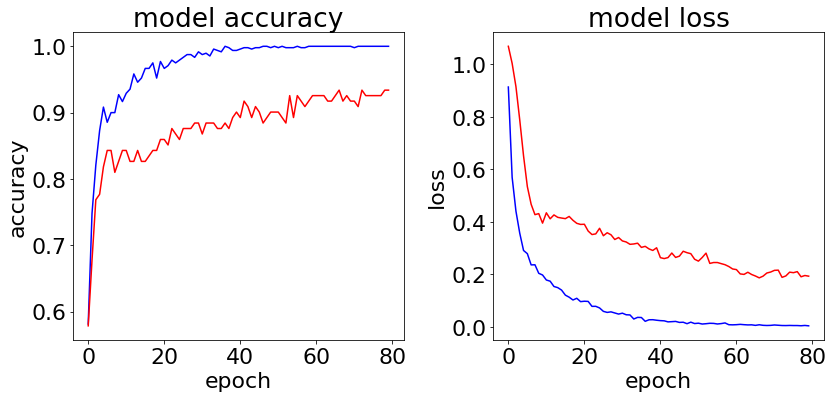

In [33]:
fig = plt.figure(figsize=(12, 6), facecolor='white')
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()

plt.show()

### Data loading and splitting

In [26]:
n_timestamps = None
n_channels = None

train_valid_inds = {}
for p_name in all_ss:
    X, Y, ax_info = load_faces_houses(datadir, P_NAME, feature_set='full')
    sss = StratifiedShuffleSplit(n_splits=1, train_size=P_TRAIN, random_state=0)
    train_valid_inds[p_name] = next(sss.split(X, Y))
    
    # We will also take this opportunity to make sure that all data sets have the same n_timestamps and n_channels
    if n_timestamps is None:
        n_timestamps, n_channels = X.shape[1:]
    if (n_timestamps != X.shape[1]) or (n_channels != X.shape[2]):
        raise ValueError("Inconsistent data shape!")

### Train model for each recording with freezing then fine-tuning

In [ ]:
BATCH_SIZE = 10
N_EPOCHS_SF = 20
N_EPOCHS_FINETUNE = 20
N_ITERS_ACROSS_SESS = 5

In [ ]:
hists = {}
for ep_ix in range(N_ITERS_ACROSS_SESS):
    for idx in np.random.permutation(len(participant_names)):
        
        # Load data for this session
        p_name = participant_names[idx]
        X, Y, ax_info = load_faces_houses(datadir, p_name, feature_set='full')
        
        X, Y, ax_info = load_macaque_pfc(datadir, sess_id, x_chunk='spiketrains', zscore=False)

        # Prepare the data for DL
        trn, vld = train_valid_inds[idx]
        ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, trn, vld, batch_size=BATCH_SIZE, max_offset=MAX_OFFSET)
        
        # Get/build the model for this session. The weights should carry over from previous learning.
        cfg_model_name = row['name'] + '_' + row['bank']
        
        # Train model
        print("Training model {} on {} ({} of {})".format(cfg_model_name, sess_id,
                                                          ep_ix + 1, N_EPOCHS_ACROSS_SESS))
        history = cfg_models[cfg_model_name].fit(x=ds_train,
                                                 epochs=N_EPOCHS_IN_SESS,
                                                 validation_data=ds_valid,
                                                 verbose=0)
        print("Ending acc and val acc: {:.3f}, {:.3f}".format(history.history['accuracy'][-1],
                                                      history.history['val_accuracy'][-1]))
        if row['exp_code'] not in hists:
            hists[row['exp_code']] = []
        hists[row['exp_code']].append(history.history)

In [ ]:
agg_hists = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
for idx, row in sess_df.iterrows():
    for k in agg_hists.keys():
        agg_hists[k].append(np.hstack([_[k] for _ in hists[row['exp_code']]]))
for k in agg_hists.keys():
    agg_hists[k] = np.vstack(agg_hists[k])

fig = plt.figure(figsize=(12, 6), facecolor='white')
plt.subplot(1, 2, 1)
plt.plot(agg_hists['accuracy'].T, 'b')
plt.plot(agg_hists['val_accuracy'].T, 'r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(agg_hists['loss'].T, 'b')
plt.plot(agg_hists['val_loss'].T, 'r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## Transfer the model to unseen data